In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
from statistics import mean

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [3]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Make cuts on data
def train_make_cuts(train_df, test_df):
    
    train_cut_df_sig = train_df[(train_df['IsB'] == 1) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_df[(train_df['IsB'] == 0) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_df[(test_df['IsB'] == 1) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_df[(test_df['IsB'] == 0) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

# Calculate Delta R
def deltaR(df, eta_col, phi_col):
    df['DeltaR'] = None 

    for i, row in df.iterrows():
        eta1 = df.loc[i, eta_col]
        eta2 = df.loc[(i+1), eta_col]
        phi1 = df.loc[i, phi_col]
        phi2 = df.loc[(i+1), phi_col]
        deltaR = np.sqrt((eta2 - eta1) ** 2 + (phi2 - phi1) ** 2)
        df.at[i, 'DeltaR'] = deltaR

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

Data preprocessing

In [5]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']  #, 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'] later add DeltaR
test_jet_cols = ['Jet1_Eta', 'Jet1_PT'] #, 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'] later add DeltaR

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Make cuts to data
train_df, test_df = train_make_cuts(train_df, test_df)

# Duplicate single features for each node
train_df = duplicate(train_df, train_jet_cols, 'Jet0_nDaughters')
test_df = duplicate(test_df, test_jet_cols, 'Jet1_nDaughters')

# Convert strings into float lists
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [15]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']  #, 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'] later add DeltaR
test_jet_cols = ['Jet1_Eta', 'Jet1_PT'] #, 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'] later add DeltaR

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = train_d_cols + train_jet_cols

In [16]:
full_train_df = train_df
full_test_df = test_df

In [17]:
# Cut out some data for quicker runs
cut_train_df = full_train_df.head(80000) 
cut_test_df = full_train_df.head(20000)

In [18]:
# Pick which size data to feed into model
train_df = cut_train_df
test_df = cut_test_df

In [19]:
training_data = train_df[train_f_cols]
testing_data = test_df[test_f_cols]

In [20]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[3401.994140625, 1900.632080078125, 50598.2734...","[321.1423034667969, 166.490966796875, 4434.608...","[-211.0, 22.0, -211.0, 22.0, -211.0, 22.0, 211...","[-292.9113464355469, -159.32656860351562, -441...","[131.66366577148438, 48.31449890136719, -431.3...","[3383.925537109375, 1893.325927734375, 50403.3...","[3.0502986907958984, 3.1262240409851074, 3.125...","[2.7191545963287354, 2.8471641540527344, -3.04...","[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 1.0, 0....","[0.00460335286334157, -100.0, -0.0049966084770...",...,"[433.4713134765625, -1000.0, 14.38490009307861...","[-292.9113464355469, -1000.0, -4413.5834960937...","[131.66366577148438, -1000.0, -431.32281494140...","[3383.925537109375, -1000.0, 50403.37109375, -...","[-1000.0, 1900.632080078125, -1000.0, 1306.569...","[-1000.0, 0.0, -1000.0, 0.0, -1000.0, 0.0, -10...","[-1000.0, 0.9658181667327881, -1000.0, 0.92338...","[-1000.0, 0.0, -1000.0, 16.4563045501709, -100...","[2.9050679847724443, 2.9050679847724443, 2.905...","[14298.395024637772, 14298.395024637772, 14298..."
1,"[3703.470947265625, 5466.64990234375, 3693.520...","[652.701904296875, 1086.208740234375, 293.9608...","[211.0, 22.0, 22.0, 211.0, -211.0, 22.0, 211.0...","[-485.0533142089844, -992.7774658203125, -258....","[436.74139404296875, 440.7293395996094, 139.29...","[3642.828125, 5357.64990234375, 3681.803466796...","[2.420473337173462, 2.299100160598755, 3.22244...","[2.408557176589966, 2.7237932682037354, 2.6479...","[1.0, 0.0, 0.0, 1.0, -1.0, 0.0, 1.0, 0.0, 0.0,...","[0.032413166016340256, -100.0, -100.0, 0.05017...",...,"[112.96279907226562, -1000.0, -1000.0, 114.350...","[-485.0533142089844, -1000.0, -1000.0, -436.25...","[436.74139404296875, -1000.0, -1000.0, 510.332...","[3642.828125, -1000.0, -1000.0, 5649.465820312...","[-1000.0, 5301.71875, 2637.77587890625, -1000....","[-1000.0, 0.0, 0.31315138936042786, -1000.0, -...","[-1000.0, 0.9833037257194519, 0.88588947057724...","[-1000.0, 30.992708206176758, 69.1164779663086...","[2.776715114373172, 2.776715114373172, 2.77671...","[26697.25661349805, 26697.25661349805, 26697.2..."
2,"[1412.9599609375, 915.8900146484375, 5576.5400...","[384.8694152832031, 252.0347442626953, 1596.46...","[22.0, 22.0, 22.0, 22.0, 22.0, -211.0, 22.0, -...","[366.9652099609375, 242.48509216308594, 1595.6...","[116.02155303955078, -68.72038269042969, -52.5...","[1359.5335693359375, 880.5299682617188, 5343.1...","[1.9745982885360718, 1.9639841318130493, 1.922...","[0.30622029304504395, -0.2761591374874115, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0,...","[-100.0, -100.0, -100.0, -100.0, -100.0, -0.06...",...,"[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[1176.526123046875, 665.0797119140625, 4459.47...","[0.0, 0.0, 0.0, -1000.0, 0.0, -1000.0, 0.0, -1...","[0.9012095928192139, 0.95644611120224, 0.96489...","[17.82766342163086, 19.74756622314453, 75.4247...","[2.3618259808748694, 2.3618259808748694, 2.361...","[9367.75144543674, 9367.75144543674, 9367.7514..."
3,"[11448.8388671875, 19374.671875, 15854.4199218...","[421.4931945800781, 492.49005126953125, 479.79...","[22.0, -211.0, 22.0, 211.0, 22.0, 22.0, 211.0,...","[-15.340408325195312, -26.413373947143555, -41...","[-421.21392822265625, -491.78125, -478.0136718...","[11441.0771484375, 19367.91015625, 15847.15820...","[3.9946482181549072, 4.365207195281982, 4.1907...","[-1.607199788093567, -1.624454379081726, -1.65...","[0.0, -1.0, 0.0, 1.0, 0

In [21]:
testing_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[3401.994140625, 1900.632080078125, 50598.2734...","[321.1423034667969, 166.490966796875, 4434.608...","[-211.0, 22.0, -211.0, 22.0, -211.0, 22.0, 211...","[-292.9113464355469, -159.32656860351562, -441...","[131.66366577148438, 48.31449890136719, -431.3...","[3383.925537109375, 1893.325927734375, 50403.3...","[3.0502986907958984, 3.1262240409851074, 3.125...","[2.7191545963287354, 2.8471641540527344, -3.04...","[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 1.0, 0....","[0.00460335286334157, -100.0, -0.0049966084770...",...,"[433.4713134765625, -1000.0, 14.38490009307861...","[-292.9113464355469, -1000.0, -4413.5834960937...","[131.66366577148438, -1000.0, -431.32281494140...","[3383.925537109375, -1000.0, 50403.37109375, -...","[-1000.0, 1900.632080078125, -1000.0, 1306.569...","[-1000.0, 0.0, -1000.0, 0.0, -1000.0, 0.0, -10...","[-1000.0, 0.9658181667327881, -1000.0, 0.92338...","[-1000.0, 0.0, -1000.0, 16.4563045501709, -100...","[2.9050679847724443, 2.9050679847724443, 2.905...","[14298.395024637772, 14298.395024637772, 14298..."
1,"[3703.470947265625, 5466.64990234375, 3693.520...","[652.701904296875, 1086.208740234375, 293.9608...","[211.0, 22.0, 22.0, 211.0, -211.0, 22.0, 211.0...","[-485.0533142089844, -992.7774658203125, -258....","[436.74139404296875, 440.7293395996094, 139.29...","[3642.828125, 5357.64990234375, 3681.803466796...","[2.420473337173462, 2.299100160598755, 3.22244...","[2.408557176589966, 2.7237932682037354, 2.6479...","[1.0, 0.0, 0.0, 1.0, -1.0, 0.0, 1.0, 0.0, 0.0,...","[0.032413166016340256, -100.0, -100.0, 0.05017...",...,"[112.96279907226562, -1000.0, -1000.0, 114.350...","[-485.0533142089844, -1000.0, -1000.0, -436.25...","[436.74139404296875, -1000.0, -1000.0, 510.332...","[3642.828125, -1000.0, -1000.0, 5649.465820312...","[-1000.0, 5301.71875, 2637.77587890625, -1000....","[-1000.0, 0.0, 0.31315138936042786, -1000.0, -...","[-1000.0, 0.9833037257194519, 0.88588947057724...","[-1000.0, 30.992708206176758, 69.1164779663086...","[2.776715114373172, 2.776715114373172, 2.77671...","[26697.25661349805, 26697.25661349805, 26697.2..."
2,"[1412.9599609375, 915.8900146484375, 5576.5400...","[384.8694152832031, 252.0347442626953, 1596.46...","[22.0, 22.0, 22.0, 22.0, 22.0, -211.0, 22.0, -...","[366.9652099609375, 242.48509216308594, 1595.6...","[116.02155303955078, -68.72038269042969, -52.5...","[1359.5335693359375, 880.5299682617188, 5343.1...","[1.9745982885360718, 1.9639841318130493, 1.922...","[0.30622029304504395, -0.2761591374874115, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0,...","[-100.0, -100.0, -100.0, -100.0, -100.0, -0.06...",...,"[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[1176.526123046875, 665.0797119140625, 4459.47...","[0.0, 0.0, 0.0, -1000.0, 0.0, -1000.0, 0.0, -1...","[0.9012095928192139, 0.95644611120224, 0.96489...","[17.82766342163086, 19.74756622314453, 75.4247...","[2.3618259808748694, 2.3618259808748694, 2.361...","[9367.75144543674, 9367.75144543674, 9367.7514..."
3,"[11448.8388671875, 19374.671875, 15854.4199218...","[421.4931945800781, 492.49005126953125, 479.79...","[22.0, -211.0, 22.0, 211.0, 22.0, 22.0, 211.0,...","[-15.340408325195312, -26.413373947143555, -41...","[-421.21392822265625, -491.78125, -478.0136718...","[11441.0771484375, 19367.91015625, 15847.15820...","[3.9946482181549072, 4.365207195281982, 4.1907...","[-1.607199788093567, -1.624454379081726, -1.65...","[0.0, -1.0, 0.0, 1.0, 0

In [22]:
# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [24]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index, batch):
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index) + x1
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)

        x3 = self.conv3(x2, edge_index) + x2
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)

        x = global_mean_pool(x3, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # decrease lr every 5 epochs by 0.1

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    scheduler.step()
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 10

# Lists to store loss and accuracy values
loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Loss: 0.6578, Train Acc: 0.6137, Test Acc: 0.6142
Epoch: 002, Loss: 0.6564, Train Acc: 0.6137, Test Acc: 0.6138
Epoch: 003, Loss: 0.6565, Train Acc: 0.6137, Test Acc: 0.6142
Epoch: 004, Loss: 0.6564, Train Acc: 0.6133, Test Acc: 0.6142
Epoch: 005, Loss: 0.6564, Train Acc: 0.6119, Test Acc: 0.6127
Epoch: 006, Loss: 0.6567, Train Acc: 0.6131, Test Acc: 0.6141
Epoch: 007, Loss: 0.6565, Train Acc: 0.6137, Test Acc: 0.6142
Epoch: 008, Loss: 0.6565, Train Acc: 0.6126, Test Acc: 0.6138
Epoch: 009, Loss: 0.6564, Train Acc: 0.6110, Test Acc: 0.6123
Epoch: 010, Loss: 0.6566, Train Acc: 0.6132, Test Acc: 0.6141
 
Grad norms:
    conv1.lin_rel.weight: 0.000979
    conv1.lin_rel.bias: 0.000000
    conv1.lin_root.weight: 0.000298
    bn1.weight: 0.000699
    bn1.bias: 0.000487
    conv2.lin_rel.weight: 0.000476
    conv2.lin_rel.bias: 0.000000
    conv2.lin_root.weight: 0.000142
    bn2.weight: 0.000584
    bn2.bias: 0.000673
    conv3.lin_rel.weight: 0.001029
    conv3.lin_rel.bias: 0.0

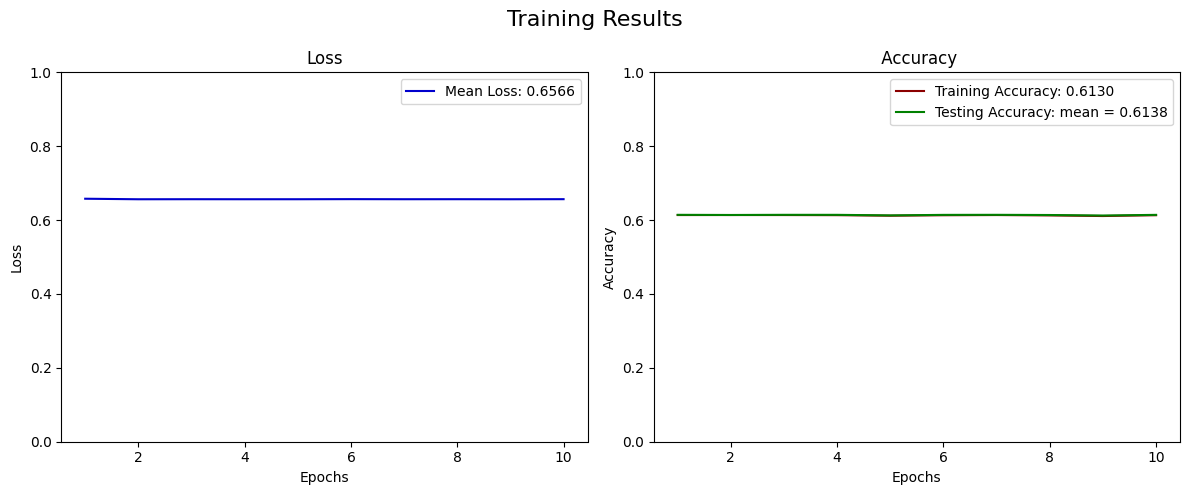

In [25]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Mean Loss: {mean_loss:.4f}"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy: {mean_train_acc:.4f}"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy: mean = {mean_test_acc:.4}"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)

Compute ROC Curve and AUC

In [26]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [27]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

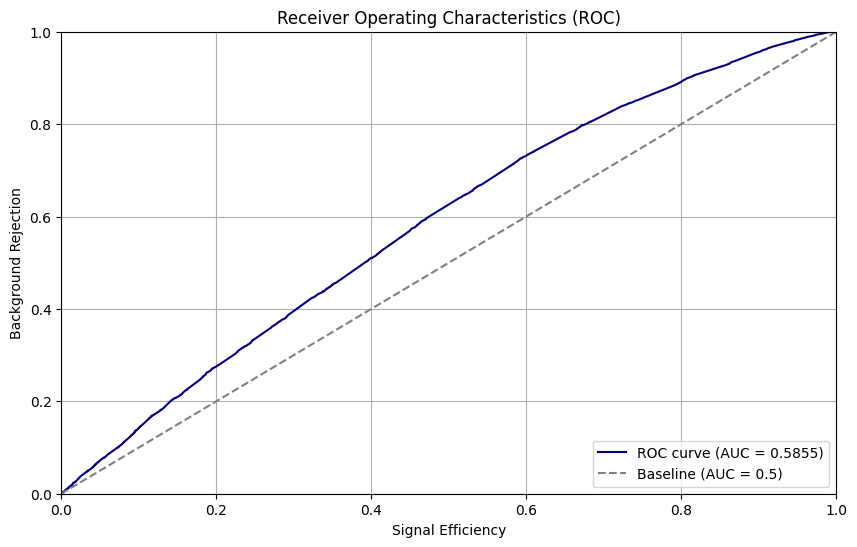

In [28]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Analyze strength of features